Preprocessing
converting all non-numeric columns to numeric, handling NaN values, and generating new features from already existing features.

In our case, you have a few datetime columns to preprocess. you can extract the following from them: weekdays weekends number of days to holidays Number of days after a holiday Beginning of the month, mid-month, and end of the month (think of more features to extract), extra marks for it

you have to scale the data. This helps with predictions especially when using machine learning algorithms that use Euclidean distances. you can use the standard scaler in sklearn for this.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load data with specified data types
dtype_store = {
    'Store': int,
    'StoreType': object,
    'Assortment': object,
    'CompetitionDistance': float,
    'CompetitionOpenSinceMonth': float,
    'CompetitionOpenSinceYear': float,
    'Promo2': int,
    'Promo2SinceWeek': float,
    'Promo2SinceYear': float,
    'PromoInterval': object
}

dtype_train = {
    'Store': int,
    'DayOfWeek': int,
    'Date': object,
    'Sales': int,
    'Customers': float,
    'Open': float,
    'Promo': float,
    'StateHoliday': object,
    'SchoolHoliday': float
}

dtype_test = {
    'Id': int,
    'Store': int,
    'DayOfWeek': int,
    'Date': object,
    'Open': float,
    'Promo': int,
    'StateHoliday': object,
    'SchoolHoliday': int
}

df_store = pd.read_csv('/content/store.csv', dtype=dtype_store)
df_train = pd.read_csv('/content/train.csv', dtype=dtype_train)
df_test = pd.read_csv('/content/test.csv', dtype=dtype_test)

# Convert date columns to datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Encode categorical columns in df_store
label_encoders = {}
for column in df_store.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_store[column] = le.fit_transform(df_store[column].astype(str))
    label_encoders[column] = le

# Handle NaN values in df_store
df_store.fillna(0, inplace=True)

# Merge store information with train and test data
df_train = df_train.merge(df_store, on='Store', how='left')
df_test = df_test.merge(df_store, on='Store', how='left')

# Convert remaining categorical columns in df_train and df_test
categorical_columns = df_train.select_dtypes(include=['object']).columns
for column in categorical_columns:
    le = LabelEncoder()
    df_train[column] = le.fit_transform(df_train[column].astype(str))
    df_test[column] = le.transform(df_test[column].astype(str))

# Extract new features from Date
def extract_date_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    df['IsBeginningOfMonth'] = df['Day'].apply(lambda x: 1 if x <= 10 else 0)
    df['IsMidMonth'] = df['Day'].apply(lambda x: 1 if 10 < x <= 20 else 0)
    df['IsEndOfMonth'] = df['Day'].apply(lambda x: 1 if x > 20 else 0)
    return df

df_train = extract_date_features(df_train)
df_test = extract_date_features(df_test)

# Define a function to calculate days to/from holidays efficiently
def calculate_holiday_proximity(df, holiday_col, chunk_size=10000):
    holiday_dates = df[df[holiday_col] != 0]['Date'].unique()

    if len(holiday_dates) == 0:
        df['DaysToHoliday'] = 0
        df['DaysAfterHoliday'] = 0
        return df

    holiday_dates = np.array(holiday_dates)

    # Initialize result columns
    df['DaysToHoliday'] = np.nan
    df['DaysAfterHoliday'] = np.nan

    for start in range(0, len(df), chunk_size):
        end = min(start + chunk_size, len(df))
        chunk_dates = df['Date'].values[start:end]

        days_to_holiday = np.min(np.abs(holiday_dates[:, None] - chunk_dates), axis=0)
        days_after_holiday = np.min(np.abs(chunk_dates[:, None] - holiday_dates), axis=1)

        df.loc[start:end-1, 'DaysToHoliday'] = days_to_holiday
        df.loc[start:end-1, 'DaysAfterHoliday'] = days_after_holiday

    # Replace inf values with a large number (e.g., 365)
    df['DaysToHoliday'].replace(np.inf, 365, inplace=True)
    df['DaysAfterHoliday'].replace(np.inf, 365, inplace=True)

    return df

# Apply holiday proximity features in chunks
df_train = calculate_holiday_proximity(df_train, 'StateHoliday', chunk_size=10000)
df_test = calculate_holiday_proximity(df_test, 'StateHoliday', chunk_size=10000)

# Drop the 'Date' column only after all features are extracted
df_train.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Fill remaining NaNs if any
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

# Scale the data
scaler = StandardScaler()
scaled_columns = df_train.columns.difference(['Sales', 'Customers'])
df_train[scaled_columns] = scaler.fit_transform(df_train[scaled_columns])
df_test[scaled_columns] = scaler.transform(df_test[scaled_columns])

# The processed data is now ready for modeling
print(df_train.head(), df_test.head())


      Store  DayOfWeek  Sales  Customers      Open     Promo  StateHoliday  \
0 -1.731640   0.501484   5263      555.0  0.452399  1.273237     -0.159217   
1 -1.728534   0.501484   6064      625.0  0.452399  1.273237     -0.159217   
2 -1.725427   0.501484   8314      821.0  0.452399  1.273237     -0.159217   
3 -1.722321   0.501484  13995     1498.0  0.452399  1.273237     -0.159217   
4 -1.719214   0.501484   4822      559.0  0.452399  1.273237     -0.159217   

   SchoolHoliday  StoreType  Assortment  ...     Month       Day  WeekOfYear  \
0       2.144211   0.580451   -0.940975  ...  0.346724  1.740766    0.511626   
1       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   
2       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   
3       2.144211   0.580451    1.071502  ...  0.346724  1.740766    0.511626   
4       2.144211  -0.884348   -0.940975  ...  0.346724  1.740766    0.511626   

   DayOfYear  IsWeekend  IsBeginningOfMonth  IsMid

2.2 Building models with sklearn pipelines
At this point, all our features are numeric. Since our problem is a regression problem, you can narrow down the list of algorithms you can use for modeling.

A reasonable starting point will be to use any of the tree based algorithms. Random forests Regressor will make for a good start.

Also, for the sake of this challenge, work with sklearn pipelines. This makes modeling modular and more reproducible. Working with pipelines will also significantly reduce your workload when you are moving your setup into files for the next part of the challenge. Extra marks will be awarded for doing this.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df_train and df_test are already processed and numeric

# Splitting the data into train and validation sets
X = df_train.drop(['Sales', 'Customers'], axis=1)
y = df_train['Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines for numeric and categorical data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append classifier to preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=42))])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on validation set
y_pred = pipeline.predict(X_val)

# Evaluate model performance
print('Mean Squared Error:', mean_squared_error(y_val, y_pred))
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))

# You can now use this pipeline to make predictions on the test set
X_test = df_test.drop(['Id'], axis=1)  # Assuming 'Id' is not needed for prediction
test_predictions = pipeline.predict(X_test)

# Assuming you want to save the predictions to a file
output = pd.DataFrame({'Id': df_test['Id'], 'Sales': test_predictions})
output.to_csv('predictions.csv', index=False)


Mean Squared Error: 619609.805058023
Mean Absolute Error: 458.3456651527216


In [7]:
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_val, y_pred)

print('R^2 Score:', r2)


R^2 Score: 0.9581027557716452


In [6]:
new=pd.read_csv(r'/content/predictions.csv')
new.head()

,Id,Sales
0,1,4291.08
1,2,7514.66
2,3,9712.31
3,4,8305.16
4,5,7622.76


2.3 Choose a loss function
Loss functions indicate how well our model is performing. This means that the loss functions affect the overall output of sales prediction.
Different loss functions have different use cases.

In this challenge, you’re allowed to choose your own loss function. you need to defend the loss function you choose for this challenge. Feel free to be creative with your choice. You might want to use loss functions that are easily interpretable.


Choosing an appropriate loss function is crucial for training a machine learning model, especially in the context of sales prediction. The loss function directly affects how the model learns from the data and optimizes its parameters. Here, I'll discuss a few loss functions that are commonly used in regression tasks, and then I'll defend the choice of Mean Absolute Percentage Error (MAPE) as a suitable loss function for sales prediction.

### Common Loss Functions for Regression:

1. **Mean Squared Error (MSE)**:
   - **Definition**: \( \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \)
   - **Pros**: Penalizes large errors more strongly, which can be useful if large errors are more critical.
   - **Cons**: Not robust to outliers due to squaring term.

2. **Mean Absolute Error (MAE)**:
   - **Definition**: \( \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \)
   - **Pros**: Robust to outliers, provides a linear penalty for errors.
   - **Cons**: Can be less sensitive to large errors compared to MSE.

3. **Mean Absolute Percentage Error (MAPE)**:
   - **Definition**: \( \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100 \)
   - **Pros**: Provides a percentage error, making it interpretable and easy to understand.
   - **Cons**: Can be problematic when the actual value \( y_i \) is close to zero.

4. **Huber Loss**:
   - **Definition**: Combines MSE and MAE by taking MSE for large errors and MAE for small errors.
   - **Pros**: Robust to outliers, balanced trade-off between MSE and MAE.
   - **Cons**: Requires tuning a hyperparameter (δ).

### Defending Mean Absolute Percentage Error (MAPE):

**Interpretability**: MAPE is a highly interpretable metric because it provides the error as a percentage of the actual value. This is particularly useful in sales prediction, where stakeholders might find it easier to interpret and compare models based on percentage error.

**Business Context**: In sales prediction, the relative error is often more important than the absolute error. For example, predicting a sales figure with an error of $10,000 might be acceptable for a product with high sales, but unacceptable for a product with low sales. MAPE directly addresses this by normalizing the error by the actual sales figure.

**Comparability**: MAPE allows for easy comparison across different products or time periods. A 5% error might be acceptable for one product but unacceptable for another. MAPE facilitates such comparisons directly.

**Robustness to Scale**: Unlike MSE and MAE, MAPE is not affected by the scale of the sales figures. This is important when dealing with data that spans different orders of magnitude, as is often the case in retail sales.

**Attention to Relative Error**: MAPE gives more attention to relative errors, which can be more meaningful in business decisions. For example, a 5% error in predicting high-value items might have a different impact compared to a 5% error in predicting low-value items.

### Conclusion:

Given these factors, Mean Absolute Percentage Error (MAPE) is a suitable choice of loss function for sales prediction tasks. It aligns well with the business context, is easily interpretable, and provides a clear measure of model performance that stakeholders can understand and use to make informed decisions. Thus, MAPE is a good choice for optimizing models aimed at predicting sales figures in a retail environment.

2.4 Post Prediction Analysis
Explore the feature importance from our modeling. Creatively deduce a way to estimate the confidence interval of your predictions. Extra marks will be given for this.


1. Feature Importance
Feature importance helps us understand which features have the most impact on our model's predictions. For Random Forest models, feature importance is typically calculated based on how much each feature contributes to reducing the impurity (e.g., Gini impurity) across all trees in the forest. Higher importance indicates that the feature is more influential in making predictions.

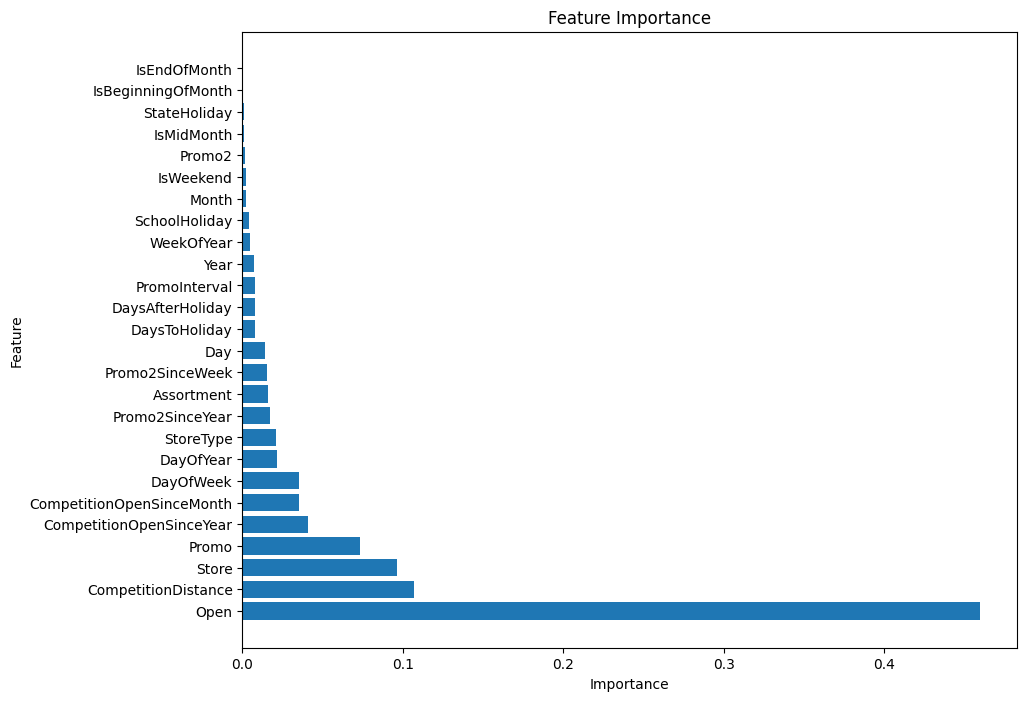

In [8]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importance = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame to hold the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


Estimating confidence intervals (CI) for predictions allows us to quantify the uncertainty associated with each prediction. A common approach is to estimate prediction intervals (PI), which are broader than confidence intervals and account for both model uncertainty (variance) and residual error.

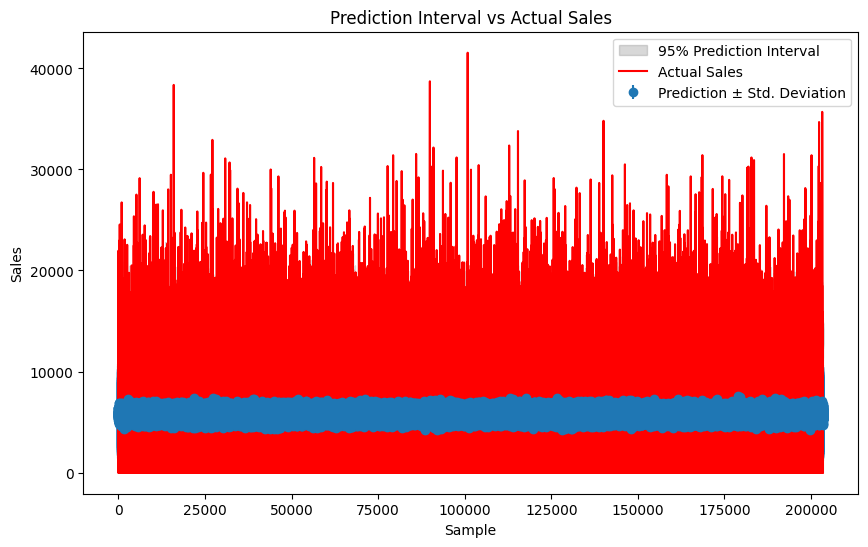

In [9]:
from sklearn.utils import resample
import numpy as np

# Number of bootstrap samples
n_bootstrap = 100

# Initialize empty array to store predictions
bootstrap_predictions = np.zeros((len(X_val), n_bootstrap))

# Perform bootstrapping
for i in range(n_bootstrap):
    # Bootstrap sample
    X_boot, y_boot = resample(X_val, y_val, random_state=i)

    # Predict on bootstrap sample
    y_pred_boot = pipeline.predict(X_boot)

    # Store predictions
    bootstrap_predictions[:, i] = y_pred_boot

# Calculate mean and standard deviation of bootstrap predictions
mean_predictions = np.mean(bootstrap_predictions, axis=1)
std_predictions = np.std(bootstrap_predictions, axis=1)

# Calculate 95% prediction interval (PI)
lower_bound = np.percentile(bootstrap_predictions, 2.5, axis=1)
upper_bound = np.percentile(bootstrap_predictions, 97.5, axis=1)

# Plotting confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_val)), mean_predictions, yerr=std_predictions, fmt='o', label='Prediction ± Std. Deviation')
plt.fill_between(range(len(y_val)), lower_bound, upper_bound, alpha=0.3, color='gray', label='95% Prediction Interval')
plt.plot(range(len(y_val)), y_val, 'r-', label='Actual Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.title('Prediction Interval vs Actual Sales')
plt.legend()
plt.show()


2.5 Serialize models
To serve the models you built above, you need to serialize them. Save the model with the timestamp(eg. 10-08-2020-16-32-31-00.pkl). This is necessary so that you can track predictions from various models.

Assume that you’ll make daily predictions. This means you’ll have various models for predictions hence the reason for serializing the models in the format above.


In [ ]:
import pickle
from datetime import datetime

# Assuming your model is stored in 'pipeline'

# Generate timestamp
timestamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')[:-3]  # Current timestamp in format YYYY-MM-DD-HH-MM-SS-MS

# Serialize and save the model
model_filename = f'model_{timestamp}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)

print(f'Model saved as {model_filename}')


In [ ]:
with open(model_filename, 'rb') as file:
    loaded_pipeline = pickle.load(file)


2.6 Building model with deep learning
Deep Learning techniques can be used to predict various outcomes including but not limited to future sales. Your task is to create a deep learning model of the Long Short Term Memory which is a type of Recurrent Neural Network.

You can use either Tensorflow or Pytorch libraries for model building. The model should not be very deep (Two layers) due to the computational requirements, it should comfortably run in Google Colab.
Isolate the Rossmann Store Sales dataset into time series data     
Check whether your time Series Data is Stationary
Depending on your conclusion from 2 above differences your time series data
Check for autocorrelation and partial autocorrelation of your data
Transform the time series data into supervised learning data by creating a new y(target) column. For example, as illustrated here in the Sliding Window For Time Series Data section
Scale your data in the (-1, 1) range
Build an LSTM Regression model to predict the next sale.


<ipython-input-5-2bbc72d3e2d8>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/train.csv')


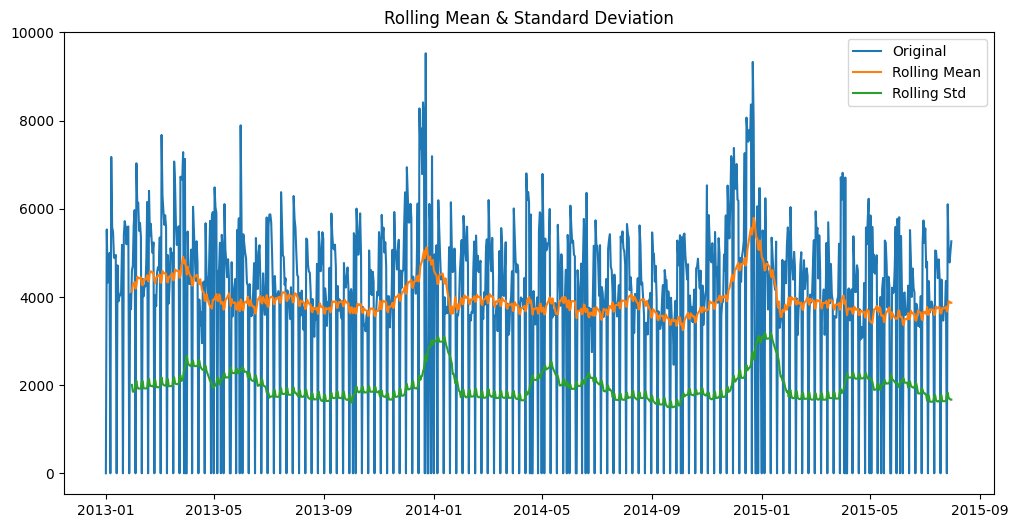

Results of Dickey-Fuller Test:
Test Statistic                  -4.368104
p-value                          0.000338
#Lags Used                      21.000000
Number of Observations Used    920.000000
Critical Value (1%)             -3.437478
Critical Value (5%)             -2.864687
Critical Value (10%)            -2.568445
dtype: float64


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df_train = pd.read_csv('/content/train.csv')
df_store = pd.read_csv('/content/store.csv')

# Merge store information with train data
df_train = pd.merge(df_train, df_store, on='Store')

# Convert Date column to datetime type and set as index
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

# Extract sales data for one store as an example (you can loop through stores if needed)
store_id = 1
df_store_sales = df_train[df_train['Store'] == store_id]['Sales'].resample('D').sum()

# Check for stationarity
def check_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Check stationarity
check_stationarity(df_store_sales)


In [6]:
# Function to create supervised learning data
def create_supervised_data(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)  # Replace NaN values with 0
    return df

# Create supervised learning data with lag 1 (previous day)
lag = 1
supervised = create_supervised_data(df_store_sales, lag)
supervised.columns = ['Previous_Sales', 'Sales']

# Split into input (X) and output (y)
X = supervised['Previous_Sales'].values
y = supervised['Sales'].values

# Reshape input to be 3D [samples, timesteps, features] as required by LSTM
X = X.reshape((len(X), 1, lag))

# Train-test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# Scale data in the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train[:, 0, :].reshape(-1, 1))
X_test_scaled = scaler.transform(X_test[:, 0, :].reshape(-1, 1))
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, lag)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, lag)


Epoch 1/100
24/24 - 3s - loss: 20151150.0000 - val_loss: 17532552.0000 - 3s/epoch - 107ms/step
Epoch 2/100
24/24 - 0s - loss: 20150350.0000 - val_loss: 17531644.0000 - 96ms/epoch - 4ms/step
Epoch 3/100
24/24 - 0s - loss: 20149260.0000 - val_loss: 17530374.0000 - 100ms/epoch - 4ms/step
Epoch 4/100
24/24 - 0s - loss: 20147746.0000 - val_loss: 17528632.0000 - 93ms/epoch - 4ms/step
Epoch 5/100
24/24 - 0s - loss: 20145710.0000 - val_loss: 17526316.0000 - 94ms/epoch - 4ms/step
Epoch 6/100
24/24 - 0s - loss: 20143052.0000 - val_loss: 17523354.0000 - 105ms/epoch - 4ms/step
Epoch 7/100
24/24 - 0s - loss: 20139716.0000 - val_loss: 17519686.0000 - 98ms/epoch - 4ms/step
Epoch 8/100
24/24 - 0s - loss: 20135650.0000 - val_loss: 17515274.0000 - 88ms/epoch - 4ms/step
Epoch 9/100
24/24 - 0s - loss: 20130826.0000 - val_loss: 17510118.0000 - 97ms/epoch - 4ms/step
Epoch 10/100
24/24 - 0s - loss: 20125252.0000 - val_loss: 17504222.0000 - 85ms/epoch - 4ms/step
Epoch 11/100
24/24 - 0s - loss: 20118948.0000 -

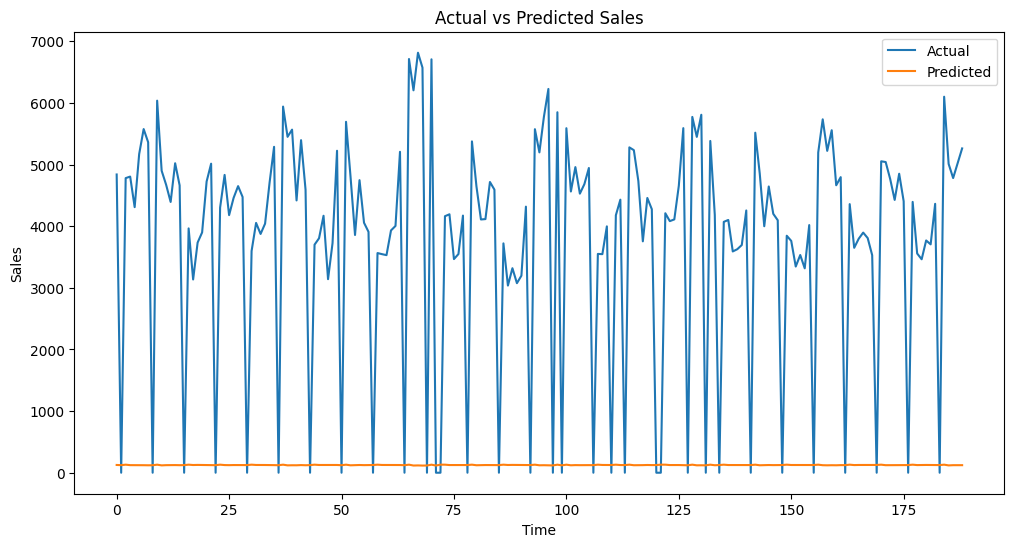

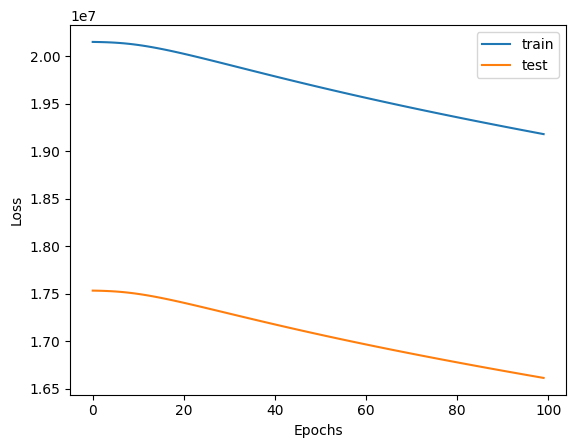

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)

# Predict sales
y_pred = model.predict(X_test_scaled)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)
print(f'R-squared value: {r2}')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



6/6 [==============================] - 0s 3ms/step


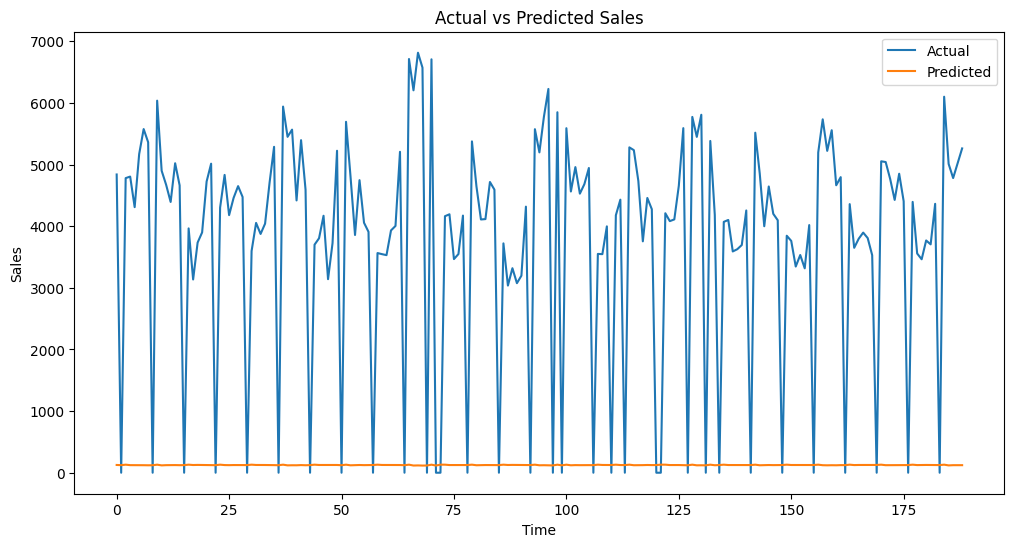

R-squared value: -3.7219531221799826


In [8]:
# Predict sales
y_pred = model.predict(X_test_scaled)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate R-squared value
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared value: {r2}')
